# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[ML][MS][HW08] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [1]:
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
from typing import Callable, Union, NoReturn, Optional, Dict, Any, List, Tuple
from collections import defaultdict

### Задание 1 (2 балла)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [3]:
def get_probs(x: np.ndarray) -> np.ndarray:
    assert x.ndim == 1
    classes, counts = np.unique(x, return_counts=True)
    return counts / x.shape[0]


def gini(x: np.ndarray) -> float:
    """
    Считает коэффициент Джини для массива меток x.
    """
    classes_probs = get_probs(x)
    return float(np.sum(classes_probs * (1 - classes_probs)))

    
def entropy(x: np.ndarray) -> float:
    """
    Считает энтропию для массива меток x.
    """
    classes_probs = get_probs(x)
    return float(-np.sum(classes_probs * np.log2(classes_probs)))


def gain(left_y: np.ndarray, right_y: np.ndarray, criterion: Callable) -> float:
    """
    Считает информативность разбиения массива меток.

    Parameters
    ----------
    left_y : np.ndarray
        Левая часть разбиения.
    right_y : np.ndarray
        Правая часть разбиения.
    criterion : Callable
        Критерий разбиения.
    """
    left_size = left_y.shape[0]
    right_size = right_y.shape[0]
    node_size = left_size + right_size

    inf_node = criterion(np.concatenate((left_y, right_y)))
    inf_left = criterion(left_y)
    inf_right = criterion(right_y)

    return node_size * inf_node - left_size * inf_left - right_size * inf_right

### Задание 2 (1 балл)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__

In [4]:
class DecisionTreeLeaf:
    """

    Attributes
    ----------
    y : dict
        Словарь, отображающий метки в вероятность того, что объект, попавший в данный лист, принадлжит классу, соответствующиему метке 
    """
    def __init__(self, node_y: np.ndarray):
        assert node_y.ndim == 1
        classes, counts = np.unique(node_y, return_counts=True)
        self.y = classes[np.argmax(counts)]
        self.probs = defaultdict(float)
        self.probs.update({
            y: prob for y, prob in zip(classes, counts / node_y.shape[0])
        })


class DecisionTreeNode:
    """

    Attributes
    ----------
    split_dim : int
        Измерение, по которому разбиваем выборку.
    split_value : float
        Значение, по которому разбираем выборку.
    left : Union[DecisionTreeNode, DecisionTreeLeaf]
        Поддерево, отвечающее за случай x[split_dim] < split_value.
    right : Union[DecisionTreeNode, DecisionTreeLeaf]
        Поддерево, отвечающее за случай x[split_dim] >= split_value. 
    """
    def __init__(self, split_dim: int, split_value: float, 
                 left: Union['DecisionTreeNode', DecisionTreeLeaf], 
                 right: Union['DecisionTreeNode', DecisionTreeLeaf]):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = left
        self.right = right

### Задание 3 (3 балла)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [5]:
class DecisionTreeClassifier:
    """
    Attributes
    ----------
    root : Union[DecisionTreeNode, DecisionTreeLeaf]
        Корень дерева.

    (можете добавлять в класс другие аттрибуты).

    """
    def __init__(self, criterion : str = "gini", 
                 max_depth : Optional[int] = None, 
                 min_samples_leaf: int = 1):
        """
        Parameters
        ----------
        criterion : str
            Задает критерий, который будет использоваться при построении дерева.
            Возможные значения: "gini", "entropy".
        max_depth : Optional[int]
            Ограничение глубины дерева. Если None - глубина не ограничена.
        min_samples_leaf : int
            Минимальное количество элементов в каждом листе дерева.

        """
        self.root = None
        self.criterion = gini if criterion == "gini" else entropy
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf
    
    def fit(self, X: np.ndarray, y: np.ndarray) -> NoReturn:
        """
        Строит дерево решений по обучающей выборке.

        Parameters
        ----------
        X : np.ndarray
            Обучающая выборка.
        y : np.ndarray
            Вектор меток классов.
        """
        assert y.ndim == 1
        self.root = self._fit(X, y, 0)

    def _fit(self, X: np.ndarray, y: np.ndarray, depth: int) -> Union[DecisionTreeLeaf, DecisionTreeNode]:
        assert X.shape[0] != 0

        if depth >= self.max_depth or np.unique(y).shape[0] == 1:
            return DecisionTreeLeaf(y)

        best = None
        best_gain = 0.0

        for split_dim in range(X.shape[1]):
            split_vals = np.unique(X[:, split_dim])
            for split_val in split_vals:
                mask = X[:, split_dim] < split_val
                information_gain = gain(y[mask], y[~mask], self.criterion)
                if information_gain > best_gain:
                    num_left = np.sum(mask, dtype=np.int32)
                    num_right = X.shape[0] - num_left
                    if num_left > self.min_samples_leaf and num_right > self.min_samples_leaf:
                        best = (split_dim, split_val)
                        best_gain = information_gain

        if best is None:
            return DecisionTreeLeaf(y)
        split_dim, split_val = best
        mask = X[:, split_dim] < split_val

        left = self._fit(X[mask], y[mask], depth + 1)
        right = self._fit(X[~mask], y[~mask], depth + 1)

        return DecisionTreeNode(split_dim, split_val, left, right)

    def predict_proba(self, X: np.ndarray) -> List[Dict[Any, float]]:
        """
        Предсказывает вероятность классов для элементов из X.

        Parameters
        ----------
        X : np.ndarray
            Элементы для предсказания.
        
        Return
        ------
        List[Dict[Any, float]]
            Для каждого элемента из X возвращает словарь 
            {метка класса -> вероятность класса}.
        """
        return list(self._predict_proba(X, self.root))

    def predict_explain(self, X: np.ndarray) -> Tuple[list, np.ndarray]:
        proba, explanation = self._predict_proba(X, self.root, explain=True)
        classes = [max(p.keys(), key=lambda k: p[k]) for p in proba]
        return classes, explanation

    def _predict_proba(self, X: np.ndarray, node: Union[DecisionTreeNode, DecisionTreeLeaf], explain: bool = False) -> Union[np.ndarray, Tuple[np.ndarray, np.ndarray]]:
        if isinstance(node, DecisionTreeLeaf):
            if not explain:
                return np.array([node.probs] * X.shape[0])
            explanation = np.empty(X.shape[0], dtype=np.object)
            explanation[:] = [tuple()] * X.shape[0]
            return np.array([node.probs] * X.shape[0]), explanation

        mask = X[:, node.split_dim] < node.split_value
        left_X = X[mask]
        right_X = X[~mask]

        res = np.empty(X.shape[0], dtype=np.object)

        if not explain:
            if left_X.shape[0] > 0:
                res[mask] = self._predict_proba(left_X, node.left)
            if right_X.shape[0] > 0:
                res[~mask] = self._predict_proba(right_X, node.right)
            return res

        left_mask = np.where(mask)[0]
        right_mask = np.where(~mask)[0]

        explanation = np.empty(X.shape[0], dtype=np.object)
        explanation[left_mask] = [((node.split_dim, node.split_value, True),)] * left_mask.shape[0]
        explanation[right_mask] = [((node.split_dim, node.split_value, False),)] * right_mask.shape[0]

        if left_X.shape[0] > 0:
            new_probs, new_expls = self._predict_proba(left_X, node.left, explain=True)
            res[mask] = new_probs
            explanation[left_mask] += new_expls
        if right_X.shape[0] > 0:
            new_probs, new_expls = self._predict_proba(right_X, node.right, explain=True)
            res[~mask] = new_probs
            explanation[right_mask] += new_expls

        return res, explanation
    
    def predict(self, X : np.ndarray) -> list:
        """
        Предсказывает классы для элементов X.

        Parameters
        ----------
        X : np.ndarray
            Элементы для предсказания.
        
        Return
        ------
        list
            Вектор предсказанных меток для элементов X.
        """
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [6]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [7]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

Наконец, протестируем дерево решений на синтетических наборах данных.

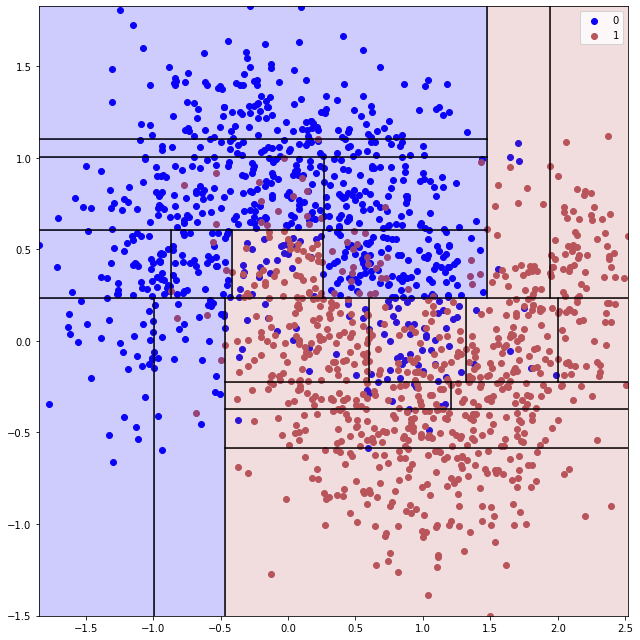

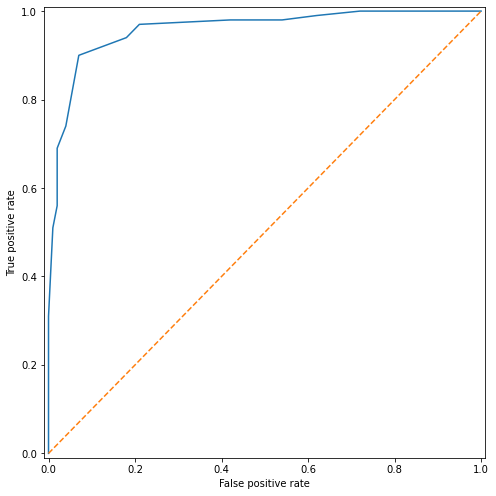

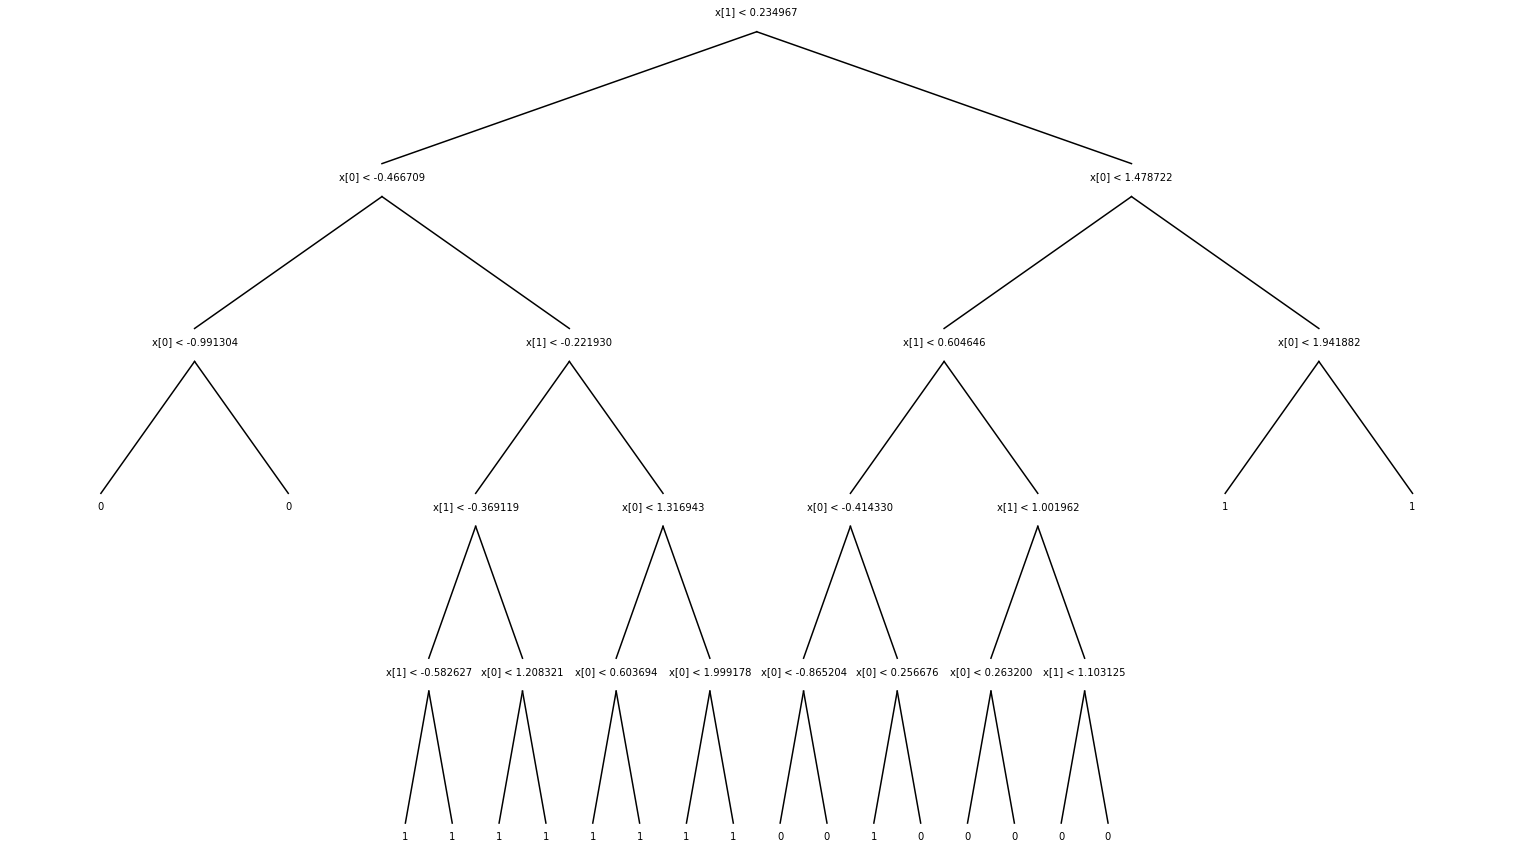

In [8]:
noise = 0.35
X, y = make_moons(1500, noise=noise)
X_test, y_test = make_moons(200, noise=noise)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

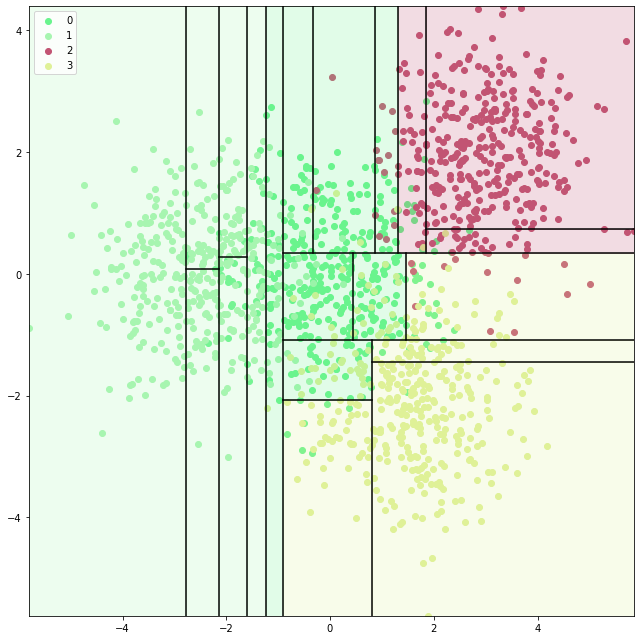

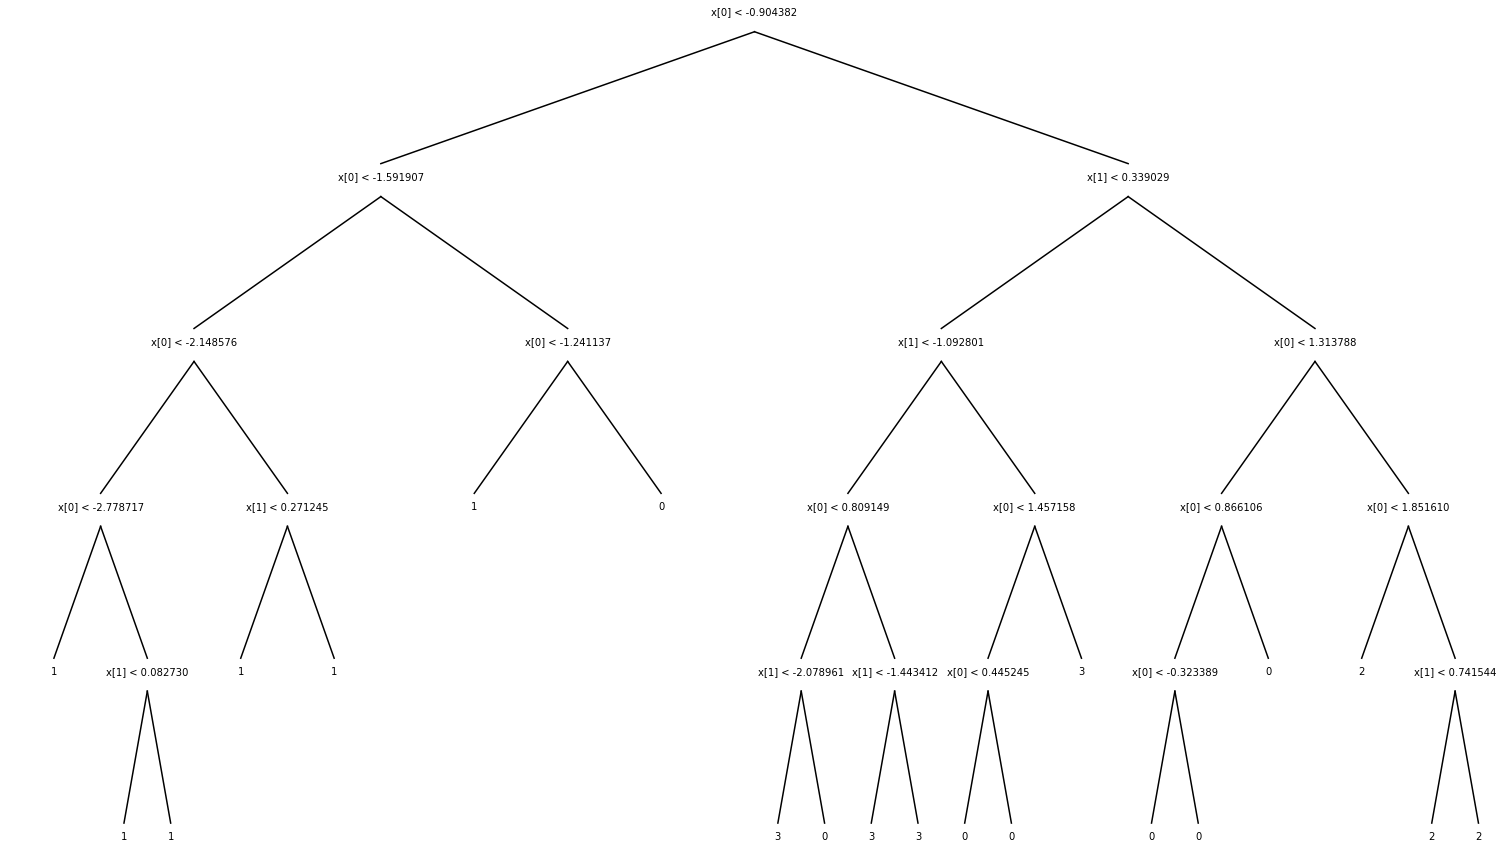

In [9]:
X, y = make_blobs(1500, 2, centers=[[0, 0], [-2.5, 0], [3, 2], [1.5, -2.0]])
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X, y)
plot_2d(tree, X, y)
draw_tree(tree)

### Задание 4 (3 балла)
У малоизвестной MMORPG Smash Art Online удалилась часть базы данных, а бэкапа не оказалось. Уволив сисадмина, тимлид начал думать, как проще и быстрее разрешить ситуацию. Оказалось, что в основном пострадала информация о классах персонажей, но зато часть внутриигровой статистики осталась нетронутой. Было решено не перезапускать игровой мир, а попробовать восстановить утерянные данные.

Посчитав, что ручное восстановление классов персонажей было бы очень долгим и вызвало бы недовольство игроков, тимлид решил пригласить специалиста по машинному обучению, который смог бы восстановить большую часть данных автоматически. 

Ваша задача - построить дерево решений, которое как можно более точно восстанавливает класс персонажа. В этом вам поможет статистика персонажей, а так же сохранившаяся часть классов персонажей. Чтобы дерево было достаточно интерпретируемым, его высота должна быть не больше `6`.


#### Оценка задания
Баллы за это задание выставляются в зависимости от точности полученного классификатора на закрытой части выборки:
1. __Точность > 50%__ - 1 балл - классификатор значительно облегчил команде игры задачу по восстановлению классов игроков. Тимлид доволен и, вероятно, захочет продолжить сотрудничество в дальнейшем
2. __Точность > 85%__ - 3 балла - классификатор сделал большую часть работы. Довольный тимлид задумчиво чешет подбородок, а затем предлагает сотрудничество на постоянной основе

__Важно: метки классов - названия, а не числа. Пусть так и остается.__

In [10]:
from itertools import product
from tqdm import tqdm
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [11]:
def read_dataset(path):
    dataframe = pandas.read_csv(path, header=1)
    dataset = dataframe.values.tolist()
    random.shuffle(dataset)
    y = [row[0] for row in dataset]
    X = [row[1:] for row in dataset]
    return np.array(X), np.array(y)

In [12]:
X, y = read_dataset("train.csv")

In [13]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)

results = [] # (num_hyps, num_folds)

depths = range(2, 30, 2)
min_samples = range(2, 50, 5)
hyperparameters = list(product(depths, min_samples))

for depth, min_samples_leaf in tqdm(hyperparameters):
    results.append([])
    for train_mask, val_mask in kf.split(X):

        X_train, X_val = X[train_mask], X[val_mask]
        y_train, y_val = y[train_mask], y[val_mask]

        dtc = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=min_samples_leaf)
        dtc.fit(X_train, y_train)
        y_pred = dtc.predict(X_val)
        accuracy = accuracy_score(y_val, y_pred)

        results[-1].append(accuracy)

100%|██████████| 140/140 [05:26<00:00,  2.33s/it]


In [14]:
results_arr = np.array(results)
mean_std_results = np.stack((results_arr.mean(axis=-1), results_arr.std(axis=-1)), axis=-1)
sort_inds = mean_std_results[:, 0].argsort()[::-1]

for index in sort_inds[:10]:
    mean, std = mean_std_results[index]
    depth, min_leaf = hyperparameters[index]
    print(f"acc: mean {mean:.3f}  std {std:.3f}  params: depth {depth:3d}  mean_leaf {min_leaf:2d}")

acc: mean 0.900  std 0.011  params: depth   6  mean_leaf  2
acc: mean 0.893  std 0.013  params: depth   8  mean_leaf  2
acc: mean 0.891  std 0.011  params: depth   6  mean_leaf  7
acc: mean 0.891  std 0.020  params: depth   8  mean_leaf  7
acc: mean 0.886  std 0.016  params: depth  10  mean_leaf  2
acc: mean 0.885  std 0.022  params: depth  16  mean_leaf  7
acc: mean 0.885  std 0.022  params: depth  22  mean_leaf  7
acc: mean 0.885  std 0.022  params: depth  26  mean_leaf  7
acc: mean 0.885  std 0.022  params: depth  20  mean_leaf  7
acc: mean 0.885  std 0.022  params: depth  18  mean_leaf  7


Делаем вывод, что оптимальные параметры --- depth=6 и min_samples_leaf=2

In [15]:
dtc = DecisionTreeClassifier(max_depth=6, min_samples_leaf=2)
dtc.fit(X, y)

### Задание 5 (1 балл)
От игроков начали поступать жалобы на то, что класс их персонажа внезапно сменился. В таких случаях модераторы смотрят на данные персонажа и пытаются восстановить его класс сами. Для того, чтобы им было проще это сделать, нужно научиться для каждого персонажа объяснять, почему дерево решений присвоило персонажу именно такой класс.

Реализуйте функцию `predict_explain(dtc, X)`. Для каждого элемента набора данных `X` она должна вернуть пару из предсказанного класса и человекочетаемой строковой записи условий, благодаря которым был предсказан класс.

In [16]:
column_names = ["monster kd", "pvp deaths", "player kd", "accuracy"]

In [19]:
def predict_explain(dtc: DecisionTreeClassifier, X: np.ndarray):
    classes, explanations = dtc.predict_explain(X)

    readable_explanations = []
    for explanation in explanations:
        readable_explanation = []
        last_dim = None
        last_sign = None
        for dim, val, is_left in explanation:
            sign = "<" if is_left else ">="

            if not (last_dim == dim and last_sign == sign):
                readable_explanation.append(f"{column_names[dim]} {sign} {val:.2f}")

            last_dim, last_sign = dim, sign

        readable_explanations.append(" | ".join(readable_explanation))

    return classes, readable_explanations

In [20]:
X, y = read_dataset("train.csv")
for pred_y, expl in zip(*predict_explain(dtc, X[:20])):
    print("Class:", pred_y)
    print("Explanation:", expl)
    print()

Class: cleric
Explanation: pvp deaths < 0.35 | player kd < 0.64 | monster kd < 2.42 | pvp deaths < 0.33 | monster kd < 0.92

Class: warrior
Explanation: pvp deaths >= 0.35 | pvp deaths < 0.92 | accuracy < 0.82 | player kd < 3.74 | monster kd >= 0.51 | pvp deaths >= 0.40

Class: rogue
Explanation: pvp deaths >= 0.35 | pvp deaths < 0.92 | accuracy >= 0.82 | monster kd >= 0.75

Class: rogue
Explanation: pvp deaths >= 0.35

Class: cleric
Explanation: pvp deaths < 0.35 | player kd < 0.64 | monster kd < 2.42 | pvp deaths < 0.33 | monster kd < 0.92

Class: rogue
Explanation: pvp deaths >= 0.35

Class: cleric
Explanation: pvp deaths < 0.35 | player kd < 0.64 | monster kd < 2.42 | pvp deaths < 0.33 | monster kd < 0.92

Class: warrior
Explanation: pvp deaths >= 0.35 | pvp deaths < 0.92 | accuracy < 0.82 | player kd < 3.74 | monster kd >= 0.51 | pvp deaths >= 0.40

Class: rogue
Explanation: pvp deaths >= 0.35

Class: cleric
Explanation: pvp deaths < 0.35 | player kd < 0.64 | monster kd < 2.42 | p